# How I Classified MNIST With Zero Training Using Only Mean Pixels
## or "Classifying MNIST Digits (part 1)"

![image](digits_plot.png)

As I work through the [fastai course](https://course.fast.ai/), I'm committed to posting something concerning each lesson I complete. This lesson was regarding Stochastic Gradient Descent and the mathematics behind neural nets. The course instructor worked through binary classification of the mnist dataset; basically, writing software to determine if a handwritten digit was a 3 or not a 3. 

The "challenge" problem this week was to use the same principles to do multi-class classification; **given an image of a handwritten number,  which digit is it most likely to be?** This problem took me a while to do and as such I've split the work into two posts. You can find [Part 2](/posts/2025_04_14_MNIST_p2) right here

**Here is a [demo of my final model](https://huggingface.co/spaces/AaronJames95/MNIST_Digit_Classifier)**.

I appreciate the layout of the fastai course for many reasons. One of the best parts of it is its emphasis on application. So I don't just learn the theory, I'm immediately applying it to code that can do things I've never done before. This week focused on what is going on behind the fastai library abstractions (or "under the hood"). If I was being asked to do this for a commercial application or personal project, I wouldn't rewrite tiny components of fastai's library that already exist. I did so here to follow the course, understand how model optimization works, and to learn more about what the library is actually doing. 


## Setting up a Performance Baseline

I learned that programming ML/DL systems and models is actually much harder than other types of software development. Typically, you know what your code is supposed to be doing and can write tests to prevent it from being obnoxiously buggy. If I have a simple function I can write a brief *test* that makes sure I'm getting the right output: 

In [1]:
# Simple code output test
def addition(x,y): return x+y

assert(addition(3,7) == 10)
print("Test passes")

assert(addition(2,2) == 5)
print("This statement never displays because the above assertion will fail, 2+2 is not 5")

Test passes


AssertionError: 

We can't do that so easily when writing ML/DL code. There are places where this type of test will work, but the main output doesn't have a concrete measurable performance that can be tested in this way. Certainly we can use loss functions and metrics to determine how well our model is doing, but even these are highly subjective in the majority of applications. 

One way we *can* get a sense of our model's performance is to **develop a baseline**. So that's what we'll be doing here. 

I found that baselining the multi-class (10-digit) model was really helpful in enabling me to understand how to apply the concepts differently. Working through it made it possible for me to even have a clue on how to tackle the actual model.

## Initializing the Notebook and Libraries

This is just the standard notebook initialization that loads the relevant fastai libraries

In [2]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

## Understanding and Manipulating the Dataset

Ok so now we need to load the full dataset that has all the digits inside of it. Took me a bit to figure out how to get the full dataset, but its just `URLS.MNIST`.


In [3]:
path = untar_data(URLs.MNIST)

The dataset has been downloaded and is in memory. I can use the `path` variable to save a reference to its top-level directory (the folder that has the downloaded data). This helps me access the data later on because I've saved a reference to where it exists. Now I need to prove to myself that I can navigate the file structure of the dataset, which I do in the next two codeblocks:

In [6]:
path.ls()

(#2) [Path('/home/aharon/.fastai/data/mnist_png/training'),Path('/home/aharon/.fastai/data/mnist_png/testing')]

In [7]:
(path/"training").ls()

(#10) [Path('/home/aharon/.fastai/data/mnist_png/training/0'),Path('/home/aharon/.fastai/data/mnist_png/training/8'),Path('/home/aharon/.fastai/data/mnist_png/training/1'),Path('/home/aharon/.fastai/data/mnist_png/training/5'),Path('/home/aharon/.fastai/data/mnist_png/training/6'),Path('/home/aharon/.fastai/data/mnist_png/training/4'),Path('/home/aharon/.fastai/data/mnist_png/training/2'),Path('/home/aharon/.fastai/data/mnist_png/training/3'),Path('/home/aharon/.fastai/data/mnist_png/training/9'),Path('/home/aharon/.fastai/data/mnist_png/training/7')]

This just helps me see how the data is structured. There's two main directories (again, just folders): training and testing. And then each of these directories have 10 sub-directories; one for each numerical digit. Within each of *those* directories there are a large number of images that contain the handwritten pictures of those digits. The training set has 60000 images, and the testing (or validation) set has 10000. 

To prove to myself that I understand the file structure, I'm going to write some code that grabs and displays one of the "8"s from the training set.

In [8]:
# Show some images, see if I can display one of each image

mnist_training_digit_paths = [p for p in (path/"training").ls().sorted()]
sample_images = []
for p in mnist_training_digit_paths:
    training_digit_im_paths = [im_path for im_path in p.ls().sorted()]
    sample_images.append(Image.open(training_digit_im_paths[42]))
sample_images[8]

What's helpful here is that I've created this variable `sample_images` so that I can display any number I want to (at least, in index 42 of the training set). This is great because i can more easily access other numbers; I don't have to rewrite the whole thing just to get a different result:

In [9]:
sample_images[7]

Awesome! I was just trying to see if I understood the file structure and I proved to myself that I did. Now I want a single variable that contains the entire dataset so I can just type something like `x['training'][6]` and get *all* of the "6"s in the training set. There's two more things I have to do. I turn each image into a pytorch tensor, and I normalize the pixel intensity matrix of each image... yeah, that's certainly some high-level jargon. Basically I'm converting the data that is contained in the .png (or w/e it is) into a format that the library can use more easily.

Here's how I made that data structure: 

<Axes: >

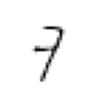

In [10]:
def create_dataset(top_dir):
    # takes a top level directory and makes the aforementioned list of 3d tensors for each digit
    
    # grab each of the paths for each digit directory in this folder
    mnist_datatype_digit_paths = [p for p in top_dir.ls().sorted()] 

    sample_images = []
    for p in mnist_datatype_digit_paths:
        # grab the path to each image included for the current digit
        training_digit_im_paths = [im_path for im_path in p.ls().sorted()] 
        # open the image as tensors for each included image
        training_image_tensors = [tensor(Image.open(im)) for im in training_digit_im_paths] 
        # turn the list of several pixel intensity matrices into a single 3D tensor
        stacked_digit_tensors = torch.stack(training_image_tensors).float() / 255 
        sample_images.append(stacked_digit_tensors)
    return sample_images
        
mnist_dataset = {}
mnist_dataset["training"] = create_dataset((path/"training"))
mnist_dataset["testing"] = create_dataset((path/"testing"))
show_image(mnist_dataset["training"][7][100])

That's one of the longer running cells, but it makes sense because its loading 70000 images into memory as tensors. But we were successful! The `mnist_dataset` variable now contains all of our data in a really simple way for us to access using the python programming lanuguage. 

## Defining our Baseline

Remember, we are trying to create a ML model that can determine which digit a given image is a drawing of. We need a baseline to determine if our model performs better than a non-ML method. How can we come up with a way of doing this without using an ML model?

Well, here's what we did in the lesson. We were only looking at a small subset of this dataset. We looked at a small percentage of the 3s and the 7s. Then, we created an "average" 3. Each of these images is a 28x28 matrix of pixel intensities, ranging from 0 to 255. If we take the *average* 28x28 matrix of pixel intensities across the training set, we can "see" what the average digit looks like:

<Axes: >

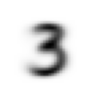

In [11]:
show_image(mnist_dataset['testing'][3].mean(0))

Perfect! It's blurry because it's the combination of the pixels densities of a few thousand threes. And if I want the average of another number (like a 7) all I have to do is change the index.

<Axes: >

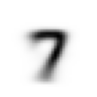

In [13]:
show_image(mnist_dataset['testing'][7].mean(0))

With our average digit, we then realized we could compare each image to it. We could get the distance between the average three and the image we want to classify mathematically. If we were only considering 3s and 7s this is simple. If the distance between the image I'm looking at and the average 3 is less than its distance to the average 7, it's probably a 3! This is exactly what we did for binary classification in the lesson.

But how do we extend this to multiclass classification? I don't just want to know if an image is a 3 or not, I want to know exactly which digit it is. Honestly, it was pretty hard for me to imagine a way to do this at first. Here's my initial reasoning:

> "Ok I'm not totally sure how to do this I think I need to make something that calculates the metrics as my goal. But I think I need to define both loss functions first. Also need something that turns the loss of a single image against each golden digit. Then, we compare our test number to each of the golden digits and find which it is closest to. What If I create a 2D tensor of vectors, and then each vector is the loss function of the input compared to each of the golden digits, shape of 1,10."

This is basically what worked! I gave each image a 1x10 vector that had its distance to *each* of the 10 digits. Then classification was simply determining which of the 10 distances was smallest (more simply, which digit was it closest to).

In [14]:
# Loss Functions
def loss_L1(x, y):
    return (x-y).abs().mean((-1,-2))

def loss_L2(x, y):
    # Alternatively, this is called RMSE
    return torch.sqrt(((x - y) ** 2).mean((-1, -2)))

We use these calculations for distance because we can't just subtract one matrix from the other. Some numbers in it would be positive and the others would be negative. If we took the average, it wouldn't really indicate the distance very accurately. These two functions are the most common ones that data scientists use for comparison in this context. We'll look later at why you might use one over the other.

So then I continue my plan. We create the comparison matrix which is several 1x10 vectors (or a single severalx10 matrix) that has the distances to each "average digit" for every image in the dataset. Then the `classify_digit` function turns each of those 1x10 vectors into a prediction by finding which digit corresponds to the smallest distance for the given image. Remember, we used the *training* data to create the average digits, and we used the *testing* data to see how well this method actually worked for prediction.

In [15]:
def create_comparison_matrix(d, loss):
    mnist_distances = []
    d_testing_images = mnist_dataset["testing"][d]
    for digit in range(len(mnist_dataset["testing"])):
        golden_digit = mnist_dataset["training"][digit].mean(0)
        mnist_distances.append(loss(d_testing_images, golden_digit))
    # the dim parameter allows me to modify the final shape. I want output[0] to give me the first classification vector length 10
    return torch.stack(mnist_distances, dim=1)


def classify_digit(d, loss):
    comp_matrix = create_comparison_matrix(d, loss)
    min_vals, min_indices = comp_matrix.min(dim=1)
    ans = (min_indices == d).sum() / len(comp_matrix)
    return ans

We're basically done! Out of my own curiosity, I wanted to see which loss function would perform better:

In [16]:
print("Loss Function Correct Prediction Comparison: \n")
print("tensor([[digit , L1Acc%, L2Acc%], \n")
metrics = []
for d in range(10):
    metrics.append([d, float(classify_digit(d, loss_L1)),float(classify_digit(d, loss_L2))])
print(tensor(metrics))
print("Average")
print(tensor(metrics).mean(0))

Loss Function Correct Prediction Comparison: 

tensor([[digit , L1Acc%, L2Acc%], 

tensor([[0.0000, 0.8153, 0.8959],
        [1.0000, 0.9982, 0.9621],
        [2.0000, 0.4234, 0.7568],
        [3.0000, 0.6089, 0.8059],
        [4.0000, 0.6680, 0.8259],
        [5.0000, 0.3262, 0.6861],
        [6.0000, 0.7871, 0.8633],
        [7.0000, 0.7646, 0.8327],
        [8.0000, 0.4425, 0.7372],
        [9.0000, 0.7760, 0.8067]])
Average
tensor([4.5000, 0.6610, 0.8173])


Ok I guess this is pretty cool. We see that the RMSE loss function (L2 Norm) performs better. Well what does better even mean? Its worst accuracy score is a 69% on the fives, whereas the L1 norm performs at a 33% for the same number. The average accuracy of L1 is 66%, whereas RMSE performs at 82%.

Why is RMSE so much better? The L1 norm simply takes the absolute value of the difference between the prediction and the target. The RMSE squares the difference. Very basically, this means that bigger mistakes are penalized more heavily than for the L1 norm. 

Does this make sense for our use case? Absolutely. We are comparing the difference in intensity of each pixel in a 28x28 grid to determine image similarity. Let's say we were comparing something to a zero. The image we were looking at had a very dark pixel in the exact center of the screen. A zero is basically a circle, so there shouldn't be anything in the center of the image. If we could point out that a big mistake like that is much further away from a zero, then we'd be in a really good spot. Since we are comparing pixel densities, it makes a lot of sense that for images that have some pixels that are way off of the ideal image we would get more accurate scores with the RMSE vs the L2 norm.

Here's another way to visualize it.

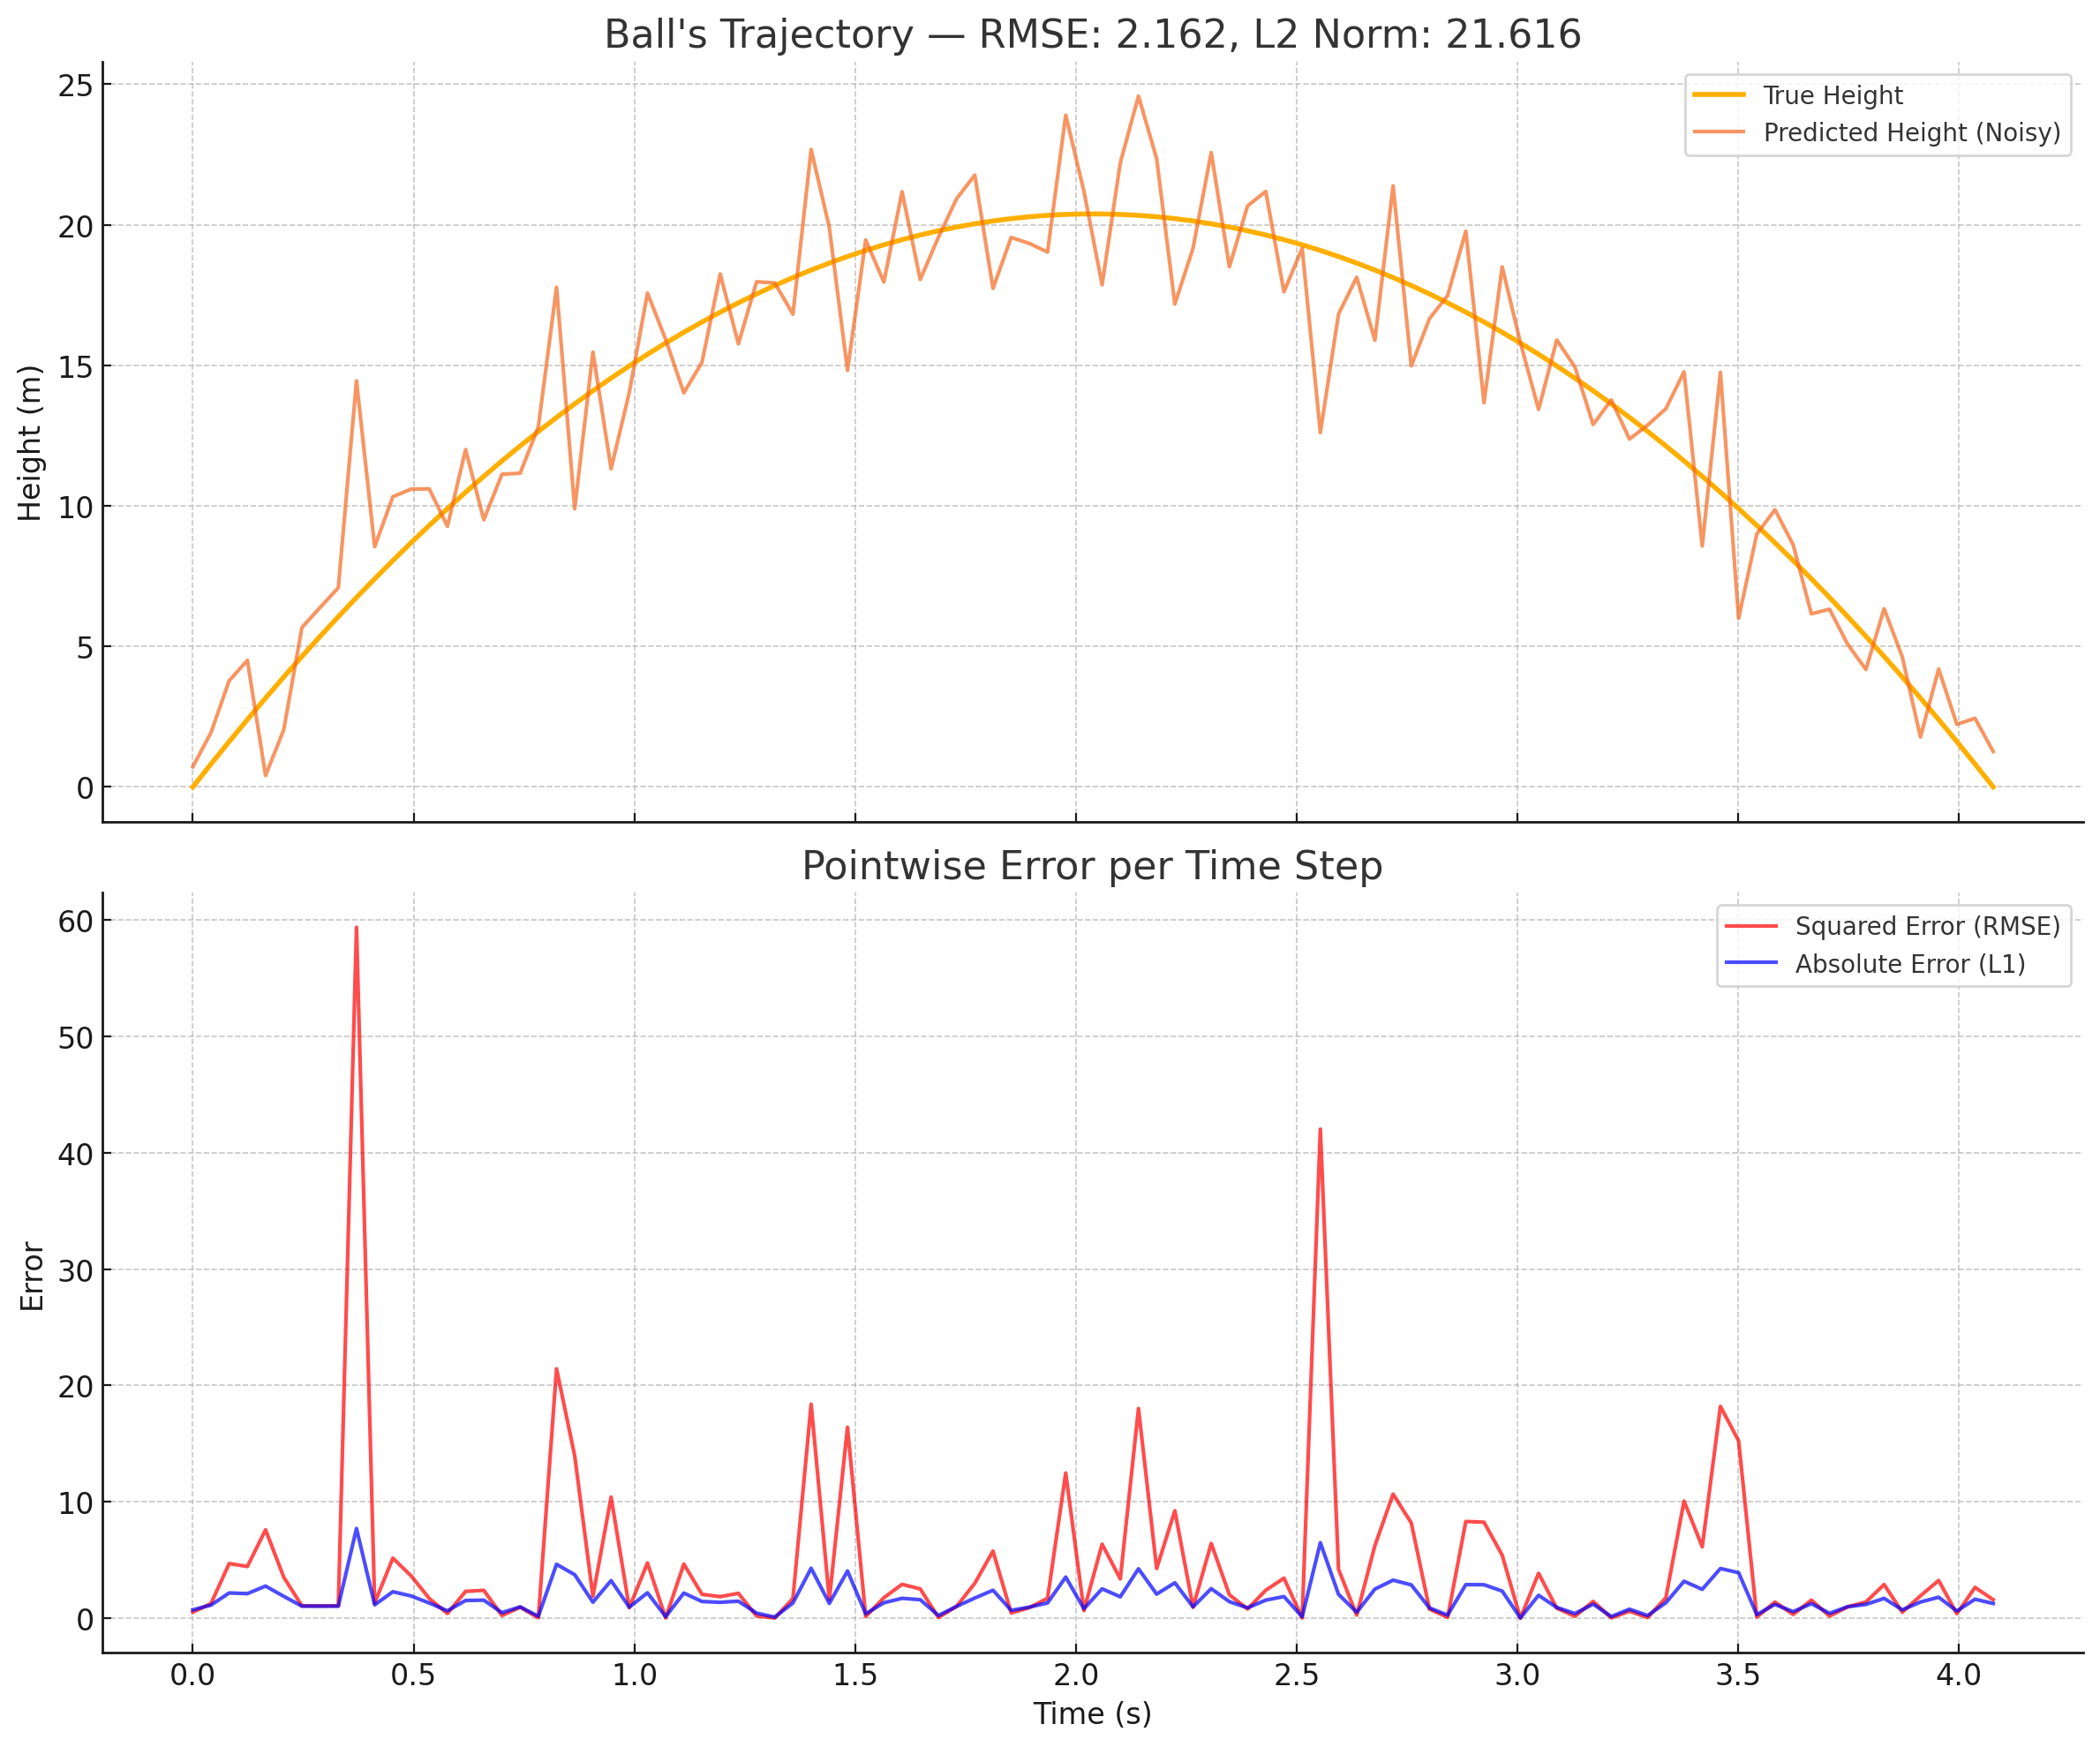

The RMSE is *way* higher on the parts of the graph where the prediction is furthest away from the true value. Bigger mistakes are penalized much more intensely than other mistakes in the same environment. L1 says "Ok, yeah that's bad", L2 says "This is insane, how are you this wrong?!"

## Conclusion
This isn't really a ML post, but it does pave the way to understand the next part in this series. We need a baseline to assess if our ML model performs better than the alternatives. In this case we saw that using the RMSE loss we could get a classification accuracy of our validation set of 81.73%. We will aim to beat that performance using Stochastic Gradient Descent in the [next post](/posts/2025_04_14_MNIST_p2). 

### Reflections
* The hardest part of this was making the conceptual shift from realizing each image needed 10 values associated with it. Once I made that leap this became way easier.
* A big part of this was just working through some of the code and fiddly bits. I had to remember and re-teach myself why sometimes the `tensor.mean(x)` changes based on what you want. I didn't include it in the post but it was part of the process.
* Comparing the two loss functions was a huge lightbulb moment for me, and the side-by-side graph was really helpful. Hopefully you learn something too! 